In [1]:
import glob
import matplotlib.image as mpimg
import numpy as np
import skimage
import cv2
import matplotlib.pyplot as plt
import logging
from scipy import ndimage as ndi
from scipy import signal
import pywt
from scipy.fftpack import fft2, ifft2
from skimage import feature, transform, registration
from skimage.feature import blob_log, blob_dog
from scipy.signal import fftconvolve
import matplotlib

In [2]:
# Create dictionary for IB images, sort by grid position, field with (img stack), and corresponding name/img position
dict1 = {}
dict2 = {}
dict3 = {}
grid_poses = ["000.000", "000.001", "000.002", "001.000", "001.001", "001.002", "002.000", "002.001", "002.002"]
hfws = ["8", "15", "20", "30", "50"]
names = ["base", "diag_down", "diag_up", "start"]
for grid_pos in grid_poses:
    dict1[grid_pos] = {}
    dict2[grid_pos] = {}
    for hfw in hfws:
        dict1[grid_pos][hfw] = {}
        dict2[grid_pos][hfw] = {}
        for name in names:
            fname1 = glob.glob(f"../../mapping_2022-09-27.01-18-18PM/{grid_pos}/{name}*{hfw}*.tif")[0]
            fname2 = glob.glob(f"../../mapping_2022-09-27.02-59-50PM/{grid_pos}/{name}*{hfw}*.tif")[0]
            img1 = mpimg.imread(fname1)
            img2 = mpimg.imread(fname2)
            dict1[grid_pos][hfw][name] = img1
            dict2[grid_pos][hfw][name] = img2
for grid_pos in ["000.000", "000.001", "001.000", "001.001"]:
    dict3[grid_pos] = {}
    for hfw in hfws:
        dict3[grid_pos][hfw] = {}
        for name in names:
            fname3 = glob.glob(f"../../mapping_2022-09-27.04-26-12PM/{grid_pos}/{name}*{hfw}*.tif")[0]
            img3 = mpimg.imread(fname3)
            dict3[grid_pos][hfw][name] = img3
# Create dictionary for Fluorescence images, sort by grid position (tile) and exposure times
# Additionally, transpose and crop the image array to the right IB image size.
fluor1 = {}
fluor2 = {}
fluor3 = {}
tiles = ["0.0", "0.1", "0.2", "1.0", "1.1", "1.2", "2.0", "2.1", "2.2"]
exposures = ["350", "500"]
for tile in tiles:
    fluor1[tile] = {}
    fluor2[tile] = {}
    for exposure in exposures:
        file1 = glob.glob(f"../../mapping_2022-09-27.01-18-18PM/fluro/{tile}*{exposure}*.tiff")[0]
        file2 = glob.glob(f"../../mapping_2022-09-27.02-59-50PM/fluro/{tile}*{exposure}*.tiff")[0]
        img1 = mpimg.imread(file1)
        img2 = mpimg.imread(file2)
        # Flip Vertical and crop to (1024,1536) same size as IB
        temp1 = np.flip(img1[512:1536, 256:1792], axis=0)
        temp2 = np.flip(img2[512:1536, 256:1792], axis=0)
        temp1_fft = np.fft.fftshift(np.fft.fft2(temp1))
        temp2_fft = np.fft.fftshift(np.fft.fft2(temp2))
        # New array to adjust for same pixelsize in both images!
        # Create array of dimension (x,y)/pixelratio with pixelratio here ~1.053
        mat1 = np.ndarray((972, 1458), dtype=np.complex128)
        mat2 = np.ndarray((972, 1458), dtype=np.complex128)
        # Create new array and crop s.t. middle point (highest value and 0 imaginary part) is preserved
        # Here x: 1024 -> 972 and y: 1536 -> 1458 meaning 52/2 and 78/2 respectively less at each edge
        mat1[:,:] = temp1_fft[26:26+972, 39:39+1458]
        mat2[:,:] = temp2_fft[26:26+972, 39:39+1458]
        fluor1[tile][exposure] =  np.abs(np.fft.ifft2(np.fft.ifftshift(mat1)))
        fluor2[tile][exposure] =  np.abs(np.fft.ifft2(np.fft.ifftshift(mat2)))
for tile in ["0.0", "0.1", "1.0", "1.1"]:
    fluor3[tile] = {}
    for exposure in exposures:
        file3 = glob.glob(f"../../mapping_2022-09-27.04-26-12PM/fluro/{tile}*{exposure}*.tiff")[0]
        img3 = mpimg.imread(file3)
        temp3 = np.flip(img3[512:1536, 256:1792], axis=0)
        temp3_fft = np.fft.fftshift(np.fft.fft2(temp3))
        mat3 = np.ndarray((972, 1458), dtype=np.complex128)
        mat3[:,:] = temp3_fft[26:26+972, 39:39+1458]
        fluor3[tile][exposure] = np.abs(np.fft.ifft2(np.fft.ifftshift(mat3)))

In [3]:
def bp_mask(image_shape: tuple,
                 bandpass_outer_radius: int,
                 bandpass_inner_radius: int = 0,
                 bandpass_sigma: float = None):

    bandpass_mask = np.zeros(image_shape)
    r, c = np.array(image_shape) / 2
    inner_circle_rr, inner_circle_cc = skimage.draw.disk(
        (r, c), bandpass_inner_radius, shape=image_shape)
    outer_circle_rr, outer_circle_cc = skimage.draw.disk(
        (r, c), bandpass_outer_radius, shape=image_shape)
    bandpass_mask[outer_circle_rr, outer_circle_cc] = 1.0
    bandpass_mask[inner_circle_rr, inner_circle_cc] = 0.0
    bandpass_mask = np.array(bandpass_mask)
    # fourier space origin should be in the corner
    bandpass_mask = np.roll(bandpass_mask,
                            (np.array(image_shape) / 2).astype(int),
                            axis=(0, 1))
    # Soft edges help avoid ringing artifacts in results
    if bandpass_sigma is not None:
        bandpass_mask = skimage.filters.gaussian(bandpass_mask.astype(float),
                                                 sigma=bandpass_sigma)
    return bandpass_mask

def normalize(image:np.ndarray) -> np.ndarray:
    mean, std = cv2.meanStdDev(image)
    norm = (image - mean) / std
    # zero_array = np.zeros(norm.shape)
    # final_img = cv2.normalize(norm,  zero_array, 0, 1, cv2.NORM_MINMAX)
    return norm

# radial spectrum of fourier space
def radial_spec(image: np.array):
    x, y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    R = np.sqrt(x ** 2 + y ** 2)
    f = lambda r: image[(R >= r - .5) & (R < r + .5)].mean()
    r = np.linspace(0, 824, num = 824)
    mean = np.vectorize(f)(r)
    return r, mean

In [4]:
# Crop images to make them square, here size (824, 824)
ib_crop = []
fl_crop = []
for i, j in zip(grid_poses, tiles):
    ib2 = dict2[i]["50"]["start"][100:924, 356:1180]
    fl2 = fluor2[j]["350"][74:898, 317:1141]
    ib_crop.append(ib2)
    fl_crop.append(fl2) 
for k, l in zip((["000.000", "000.001", "001.000", "001.001"]), (["0.0", "0.1", "1.0", "1.1"])):
    ib3 = dict3[k]["50"]["start"][100:924, 356:1180]
    fl3 = fluor3[l]["350"][74:898, 317:1141]
    ib_crop.append(ib3)
    fl_crop.append(fl3)


In [141]:
ib_img = []
fl_350 = []
fl_500 = []
for i, j in zip(grid_poses, tiles):
    ib2 = dict2[i]["50"]["start"][26:998, 39:1497]
    fl2 = fluor2[j]["350"]
    fl500 = fluor2[j]["500"]
    ib_img.append(ib2)
    fl_350.append(fl2) 
    fl_500.append(fl500) 

for k, l in zip((["000.000", "000.001", "001.000", "001.001"]), (["0.0", "0.1", "1.0", "1.1"])):
    ib3 = dict3[k]["50"]["start"][26:998, 39:1497]
    fl3 = fluor3[l]["350"]
    fl500_2 = fluor3[l]["500"]
    ib_img.append(ib3)
    fl_350.append(fl3)
    fl_500.append(fl500_2) 

In [5]:
# create circular mask with smooth Gaussian drop-off
def circ_mask(image:np.ndarray, mask_radius:int):
    zero_array = np.zeros(image.shape)
    mask = cv2.circle(zero_array, (412, 412), mask_radius, (1, 1, 1), -1) 
    smooth_mask = ndi.gaussian_filter(mask, 5)
    masked = image * smooth_mask
    return masked

In [76]:
ion = []
light = []
for i in range(13):
    ib = (circ_mask(normalize(ib_crop[i]), mask_radius=400))
    ion.append(ib)
    lm = (circ_mask(normalize(fl_crop[i]), mask_radius=200))
    light.append(lm)

In [142]:
img1 = []
img2 = []
img3 = []
for i in range(13):
    ib = normalize(ib_img[i])
    img1.append(ib)
    lm = normalize(fl_350[i])
    img2.append(lm)
    lm2 = normalize(fl_500[i])
    img3.append(lm2)

In [22]:
corr = np.corrcoef(ion[0], light[0])
# Find the pair of pixels with the highest correlation coefficient
# (the indices of the maximum value in the matrix)
max_index = np.argmax(corr)

# Convert the flat index to row and column indices
row, col = np.unravel_index(max_index, corr.shape)

# Print the coordinates of the best match
print(f"Best match at coordinates: x1={row}, y1={col}, x2={row}, y2={col}")

Best match at coordinates: x1=0, y1=0, x2=0, y2=0


min_loc=(0, 0), max_loc=(0, 0)


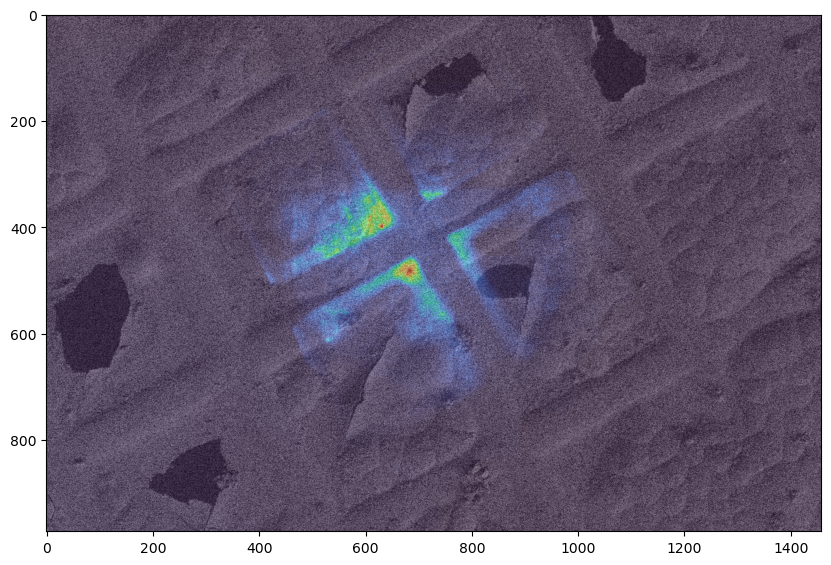

In [164]:
image1 = img1[0]
image2 = img3[0]


# Ensure that the images are 8-bit unsigned integers or 32-bit floating-point numbers
template = image2.astype(np.float32)
image = image1.astype(np.float32)

# Select a small template image from the center of the image
template_width = template.shape[1] // 2
template_height = template.shape[0] // 2
template = image2[image.shape[0] // 2 - template_height // 2: image.shape[0] // 2 + template_height // 2,
                 image.shape[1] // 2 - template_width // 2: image.shape[1] // 2 + template_width // 2]

template = np.pad(template, ((0, 972 - 486), (0, 1458 - 728)), 'constant')

template = image2.astype(np.float32)
image = image1.astype(np.float32)


# Use the matchTemplate function to compare the template to the image
result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF)

# Find the coordinates of the best match in the image
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
print(f"min_loc={min_loc}, max_loc={max_loc}")

# Calculate the error between the two images as the difference in the
# coordinates of the best match
error = (max_loc[0] - image.shape[0] // 2 + template_height // 2)**2 + (max_loc[1] - image.shape[1] // 2 + template_width // 2)**2

# Shift the template image by the error in order to align it with the image
template_aligned = np.roll(image2, max_loc, axis=(0,1))

# Visualize the resulting overlay
plt.figure(figsize = (10,10))
plt.imshow(image1, cmap='gray')
plt.imshow(template_aligned, alpha=0.5, cmap='turbo')

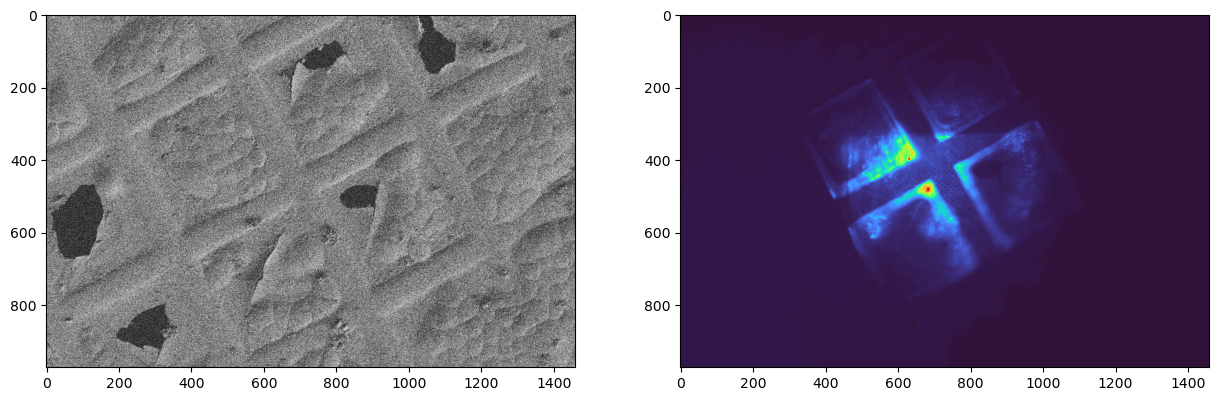

In [176]:
fig, ax = plt.subplots(1,2,figsize=(15,15))
ax[0].imshow(image, cmap='gray')
ax[1].imshow(template, cmap='turbo')
plt.show()

In [163]:
np.shape(image1)

(972, 1458)

[568441 568441]


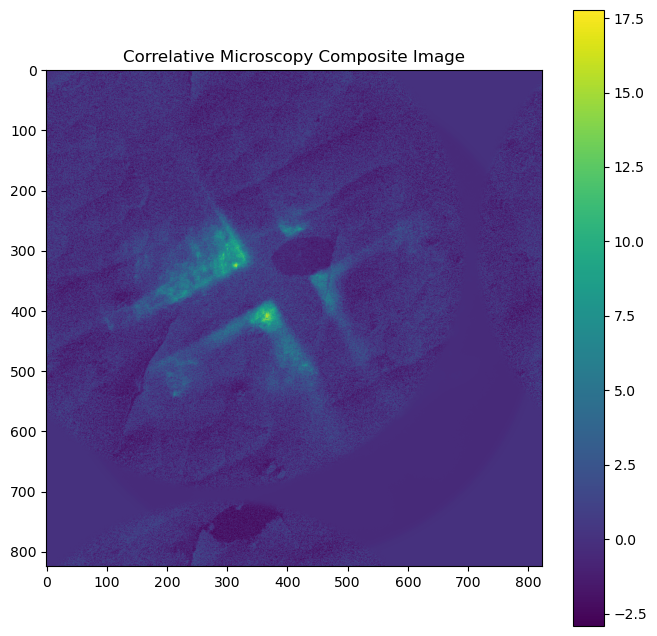

In [52]:
img1 = ion[0]
img2 = light[0]

fft1 = np.fft.fft2(img1)
fft2 = np.fft.fft2(img2)
conj_fft2 = np.conj(fft2)
corr = fft1 * conj_fft2
corr_map = np.fft.ifft2(corr)
max_index = np.argmax(corr_map)
shift = max_index - (img1.shape[0] // 2, img1.shape[1] // 2)
img1_aligned = np.roll(img1, shift, axis=(0, 1))
composite_img = img1_aligned + img2

fig = plt.figure(figsize=(8, 8))
plt.imshow(composite_img)
plt.title('Correlative Microscopy Composite Image')
plt.colorbar()
plt.show()

(262, 96)


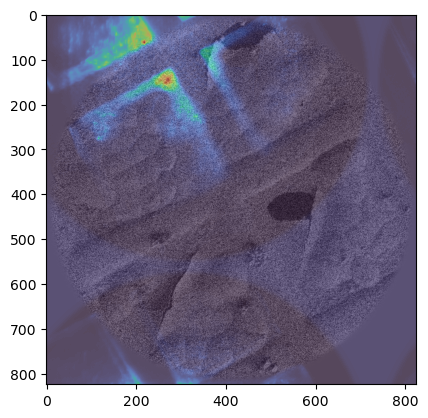

In [57]:
# Calculate the shift between the two images using the register_translation function from scikit-image
shift, error, diffphase = registration.phase_cross_correlation(ion[1], light[1])

# Round the shift to the nearest integer and convert to a tuple
shift = tuple(np.round(shift).astype(int))

# Shift the ion beam image using the calculated shift
shifted_img2 = np.roll(img2, (-shift[0], -shift[1]), axis=(0, 1))

print(shift)
# Create a new figure and set the colormap to 'turbo'
fig, ax = plt.subplots()
ax.imshow(img1, cmap='gray', alpha=1)
ax.imshow(shifted_img2, cmap='turbo', alpha=0.5)

# Show the overlaid image
plt.show()

In [44]:
from skimage.feature import peak_local_max
from skimage.filters import gaussian
from skimage.registration import phase_cross_correlation


def correlative_microscopy(img1, img2):
    # Smooth the images using a Gaussian filter
    img1 = gaussian(img1, sigma=5)
    img2 = gaussian(img2, sigma=5)

    # Compute the cross-correlation of the images using phase_cross_correlation
    shift, error, diffphase = phase_cross_correlation(img1, img2, upsample_factor=10)

    # Find the maximum peak in the cross-correlation map
    peak_size = 50
    corr_peak = ndi.filters.maximum_filter(np.real(corr), footprint=np.ones((peak_size, peak_size)))
    peaks = peak_local_max(corr_peak, min_distance=peak_size)
    idx = np.argmax(corr_peak[peaks[:, 0], peaks[:, 1]])
    maxX, maxY = peaks[idx]

    # Compute the shift error using the coordinates of the maximum peak
    cen = np.asarray(corr_peak.shape) / 2
    err = np.array(cen - [maxX, maxY], int)

    return err

In [46]:
err = correlative_microscopy(ion[0], light[0])


C:\Users\phipo\AppData\Local\Temp\ipykernel_4172\288422147.py:16: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  corr_peak = ndi.filters.maximum_filter(np.real(corr), footprint=np.ones((peak_size, peak_size)))


In [50]:
err

array([ -77, -314])

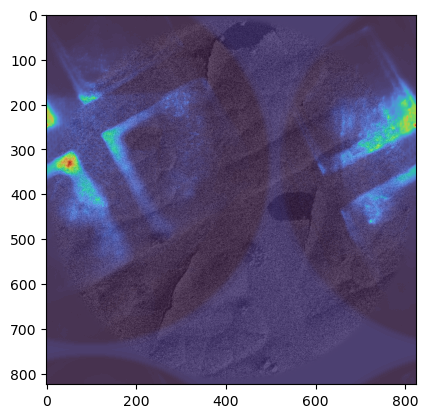

In [49]:
plt.imshow(ion[0], cmap='gray', alpha=1)
plt.imshow(np.roll(light[0], err, axis=(0,1)), cmap='turbo', alpha=0.7)

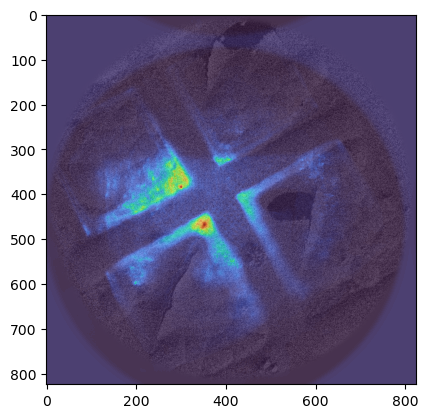

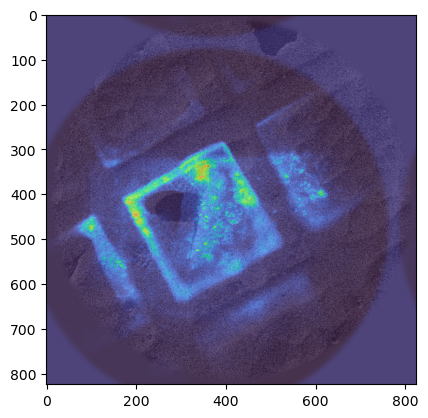

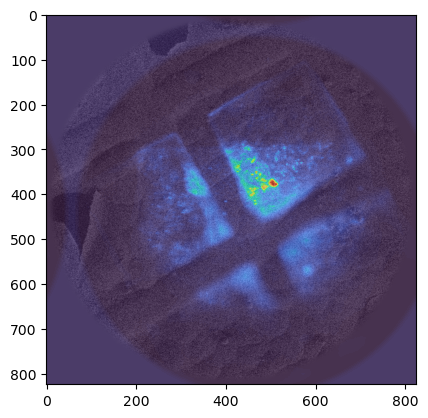

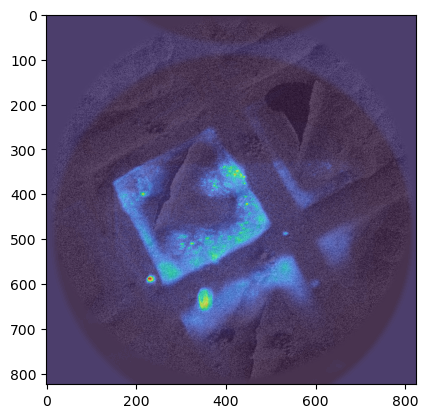

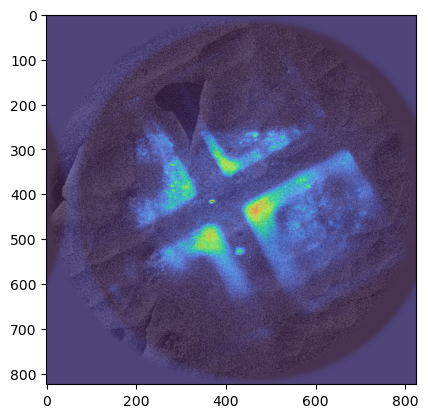

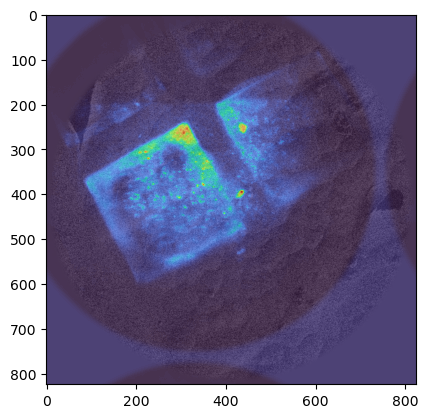

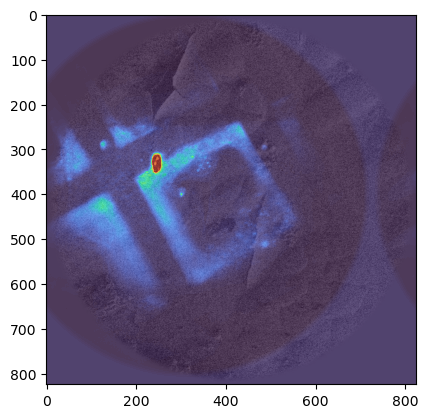

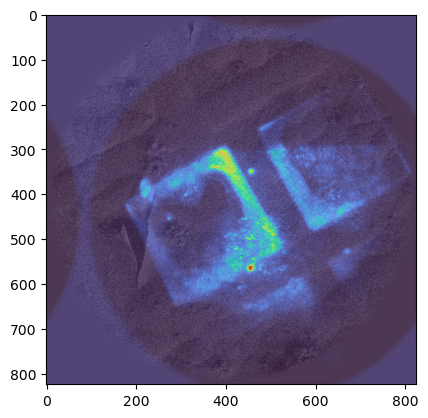

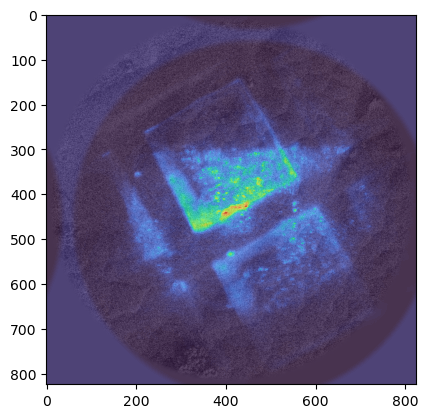

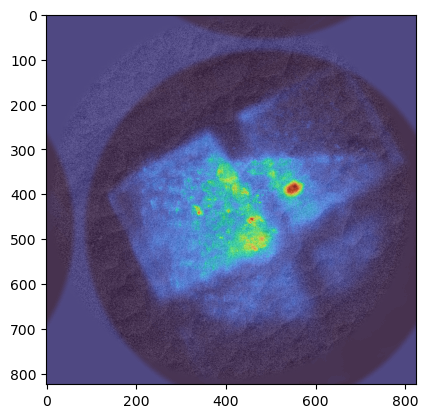

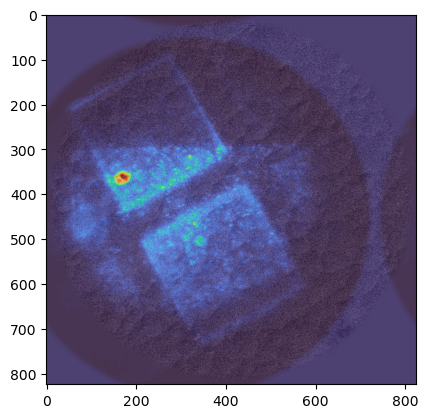

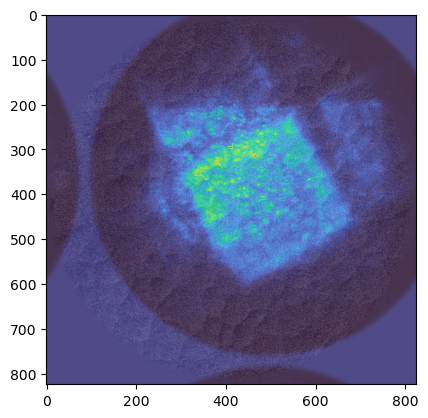

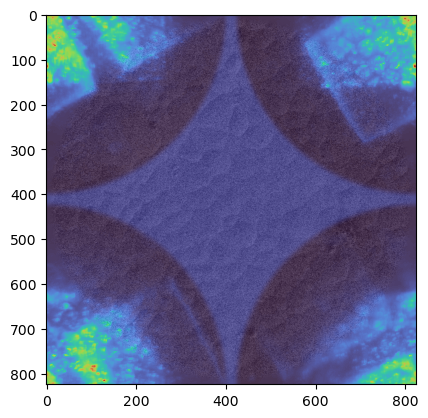

In [35]:
for i in range(13):
    plt.imshow(ion[i], cmap='gray', alpha=1)
    plt.imshow(np.roll(light[i], -errs[i], axis=(0,1)), cmap='turbo', alpha=0.7)
    plt.show()